In [1]:
%load_ext autoreload


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import sys
import os

# Add the src directory to the path
sys.path.append("../src")

from training import RKMStiefelLightning, load_config, load_model
from prepare_data import get_dataloader
from supervised_ksc_model import RKM_Stiefel

# Load configuration
config_path = "../config/config.yaml"
config = load_config(config_path)

# Load the latest trained model
date = "20250401_000418"
model_path = f"../rkm_stiefel_model_{date}.pth"
attributes_path = f"../rkm_stiefel_attributes_{date}.pth"
if os.path.exists(model_path):
    # Create data loader
    data_loader = get_dataloader(config)
    
    # Get a batch of data for visualization
    data_iter = iter(data_loader)
    points, labels = next(data_iter)
    
    # Initialize the model with the same configuration
    model = RKMStiefelLightning(config)
    
    loaded_model, loaded_attributes = load_model(model_path, attributes_path)





Model loaded successfully from ../rkm_stiefel_model_20250401_000418.pth
Model attributes loaded from ../rkm_stiefel_attributes_20250401_000418.pth


In [10]:
print(loaded_attributes.keys())

loaded_model.centering_term = torch.tensor(loaded_attributes["centering_term"])

dict_keys(['Ut', 'centering_term', 'config', 'timestamp'])


In [11]:
# Get the embeddings
with torch.no_grad():
   phi, e, h, x_tilde, dcos, Dinv = loaded_model(points)

print(phi.shape)





torch.Size([64, 16])


In [21]:

# Get the embeddings
with torch.no_grad():
    for batch, labels in data_loader:
        batch_phi, batch_e, h, batch_x_tilde, dcos, Dinv = loaded_model(batch)
        phi = torch.cat((phi, batch_phi), dim=0)
        e = torch.cat((e, batch_e), dim=0)
        x_tilde = torch.cat((x_tilde, batch_x_tilde), dim=0)
        Dinv = torch.cat((Dinv, Dinv), dim=0)
        dcos = torch.cat((dcos, dcos), dim=0)
        labels_batch = labels.clone()
        labels = torch.cat((labels, labels_batch), dim=0)
        points = batch.clone()
        points = torch.cat((points, points), dim=0)
        print(f"Batch size: {batch.shape}")

print(phi.shape)

Batch size: torch.Size([64, 2])
Batch size: torch.Size([64, 2])
Batch size: torch.Size([64, 2])
Batch size: torch.Size([64, 2])
Batch size: torch.Size([64, 2])
Batch size: torch.Size([64, 2])
Batch size: torch.Size([64, 2])
Batch size: torch.Size([64, 2])
Batch size: torch.Size([64, 2])
Batch size: torch.Size([24, 2])
torch.Size([4864, 16])


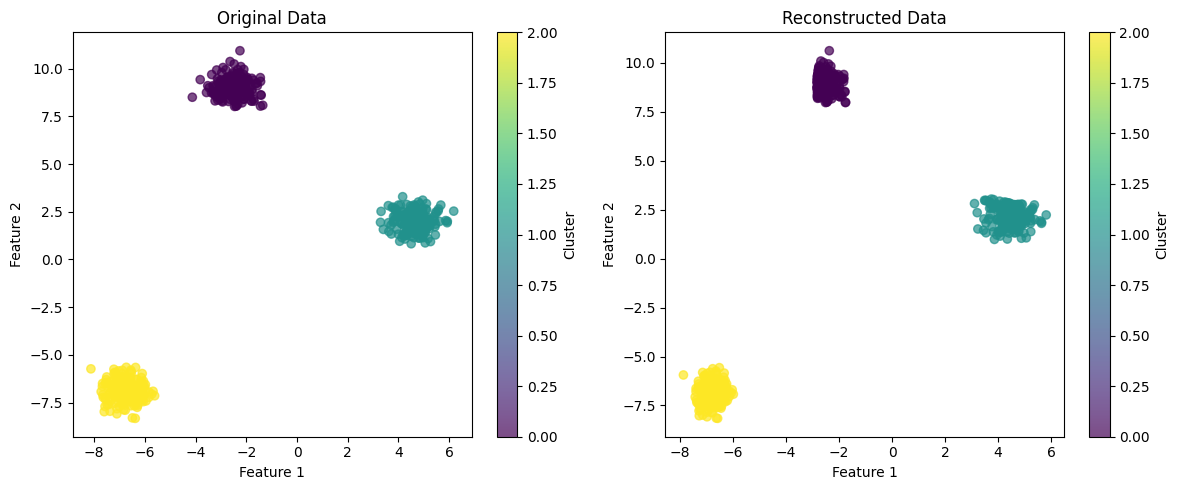

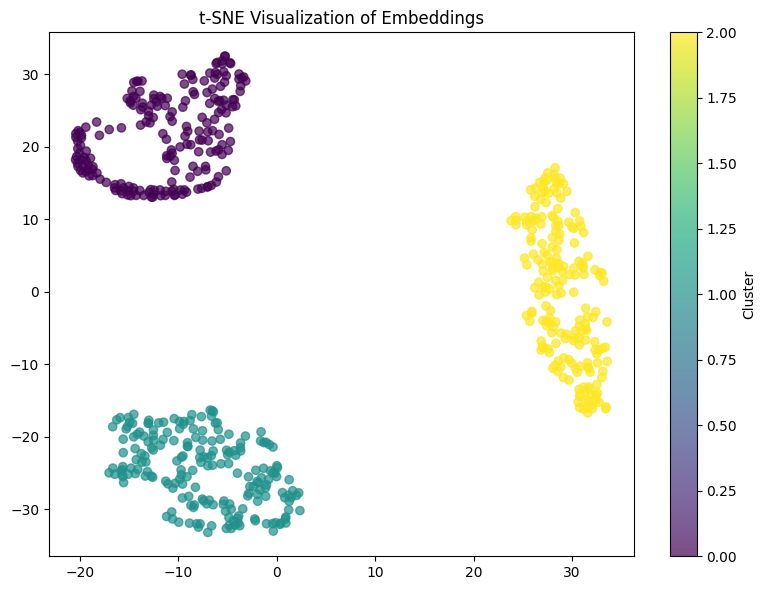

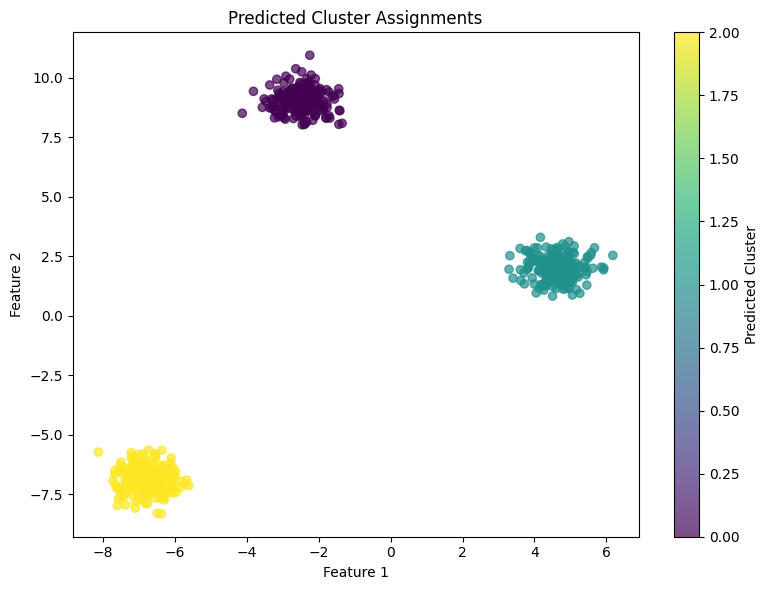

In [24]:
# Get all data at once from the data loader
all_points = []
all_labels = []
for batch, labels in data_loader:
    all_points.append(batch)
    all_labels.append(labels)

all_points = torch.cat(all_points, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Process all data through the model
with torch.no_grad():
    phi, e, h, x_tilde, dcos, Dinv = loaded_model(all_points)

# Convert to numpy for visualization
embeddings = phi.detach().cpu().numpy()
original_data = all_points.detach().cpu().numpy()
reconstructed_data = x_tilde.detach().cpu().numpy()
labels = all_labels.detach().cpu().numpy()

# Plot original data vs reconstructed data
plt.figure(figsize=(12, 5))

# Original data
plt.subplot(1, 2, 1)
plt.scatter(original_data[:, 0], original_data[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.title('Original Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')

# Reconstructed data
plt.subplot(1, 2, 2)
plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.title('Reconstructed Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

# Visualize embeddings if dimensionality is high
if phi.shape[1] > 3:
    # Use t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.title('t-SNE Visualization of Embeddings')
    plt.colorbar(label='Cluster')
    plt.tight_layout()
    plt.show()
else:
    # If embedding dimension is 3, visualize in 3D
    if phi.shape[1] == 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], 
                            c=labels, cmap='viridis', alpha=0.7)
        plt.colorbar(scatter, ax=ax, label='Cluster')
        ax.set_title('3D Embeddings')
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')
        ax.set_zlabel('Dimension 3')
        plt.show()
    # If embedding dimension is 2, visualize in 2D
    elif phi.shape[1] == 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis', alpha=0.7)
        plt.title('2D Embeddings')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.colorbar(label='Cluster')
        plt.tight_layout()
        plt.show()

# Visualize cluster assignments
cosine_distances = dcos.detach().cpu().numpy()
predicted_clusters = np.argmin(cosine_distances, axis=1)

plt.figure(figsize=(8, 6))
plt.scatter(original_data[:, 0], original_data[:, 1], c=predicted_clusters, cmap='viridis', alpha=0.7)
plt.title('Predicted Cluster Assignments')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Predicted Cluster')
plt.tight_layout()
plt.show()
